<h1 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Alzheimer MR Images Classification</h1>



<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Importing Necessary Libraries</h2>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

In [4]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU active! - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Class Distribution</h2>

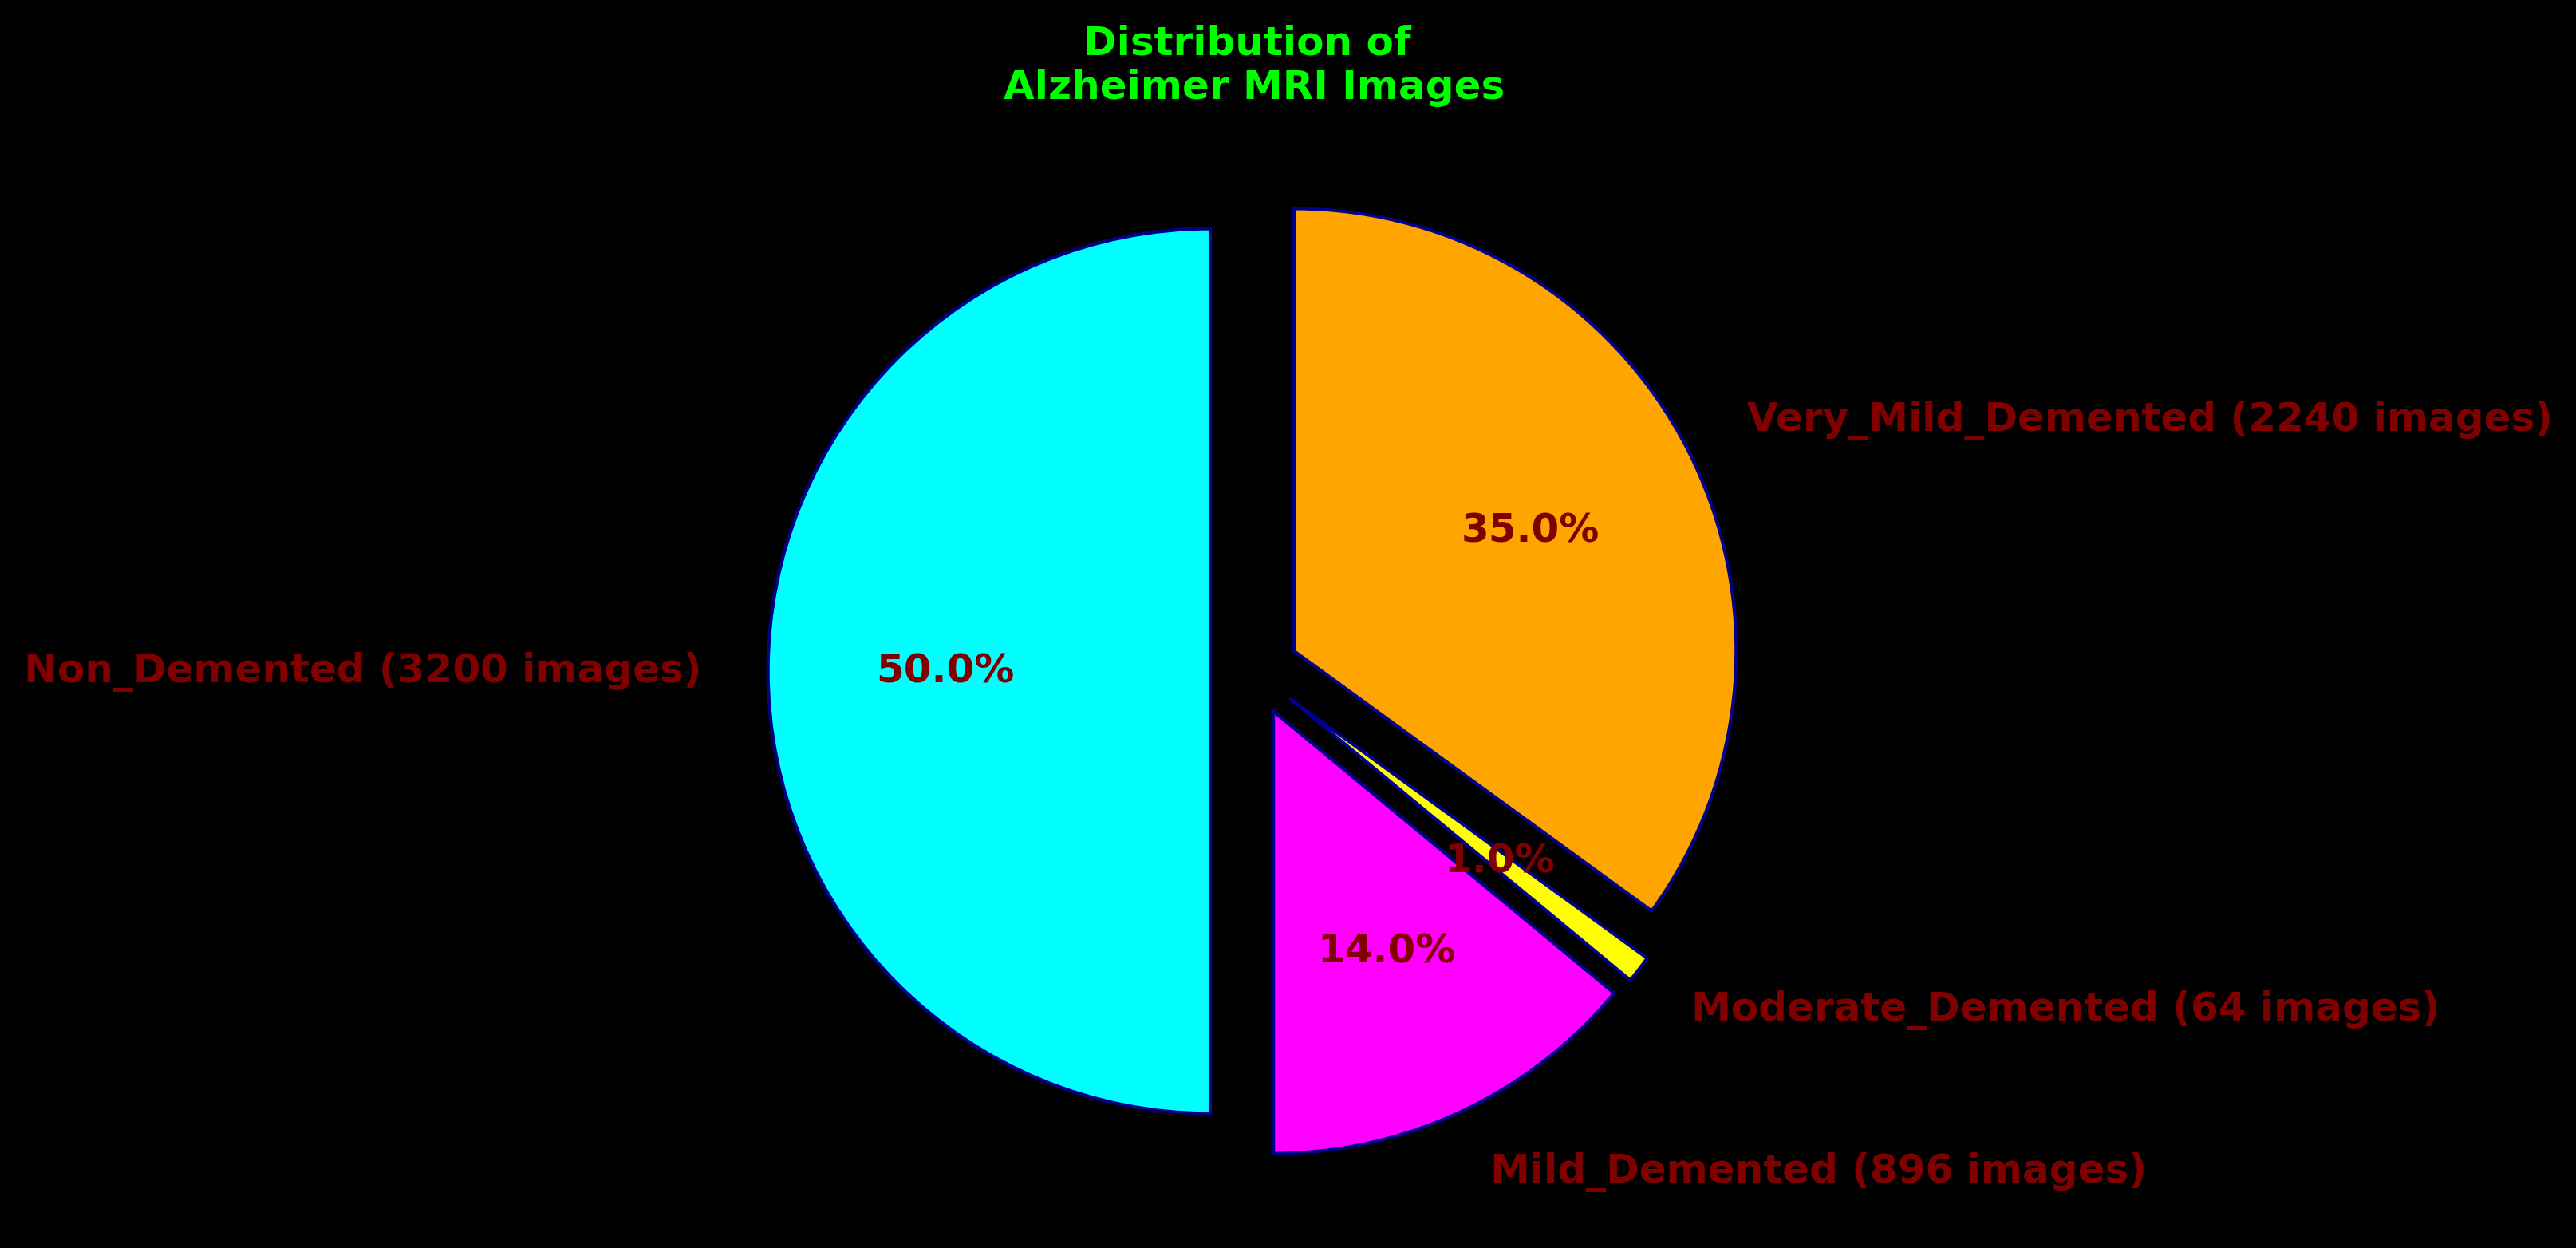

In [6]:
import os
import matplotlib.pyplot as plt

class_dist = {}

def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
    
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,) * len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    # Define custom colors
    colors = ['cyan', 'magenta', 'yellow', 'orange']  # Add more colors if needed

    # Create the pie chart
    plt.figure(facecolor='black')  # Set background color to black
    plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12, "color": "maroon", "fontweight": "bold"}, wedgeprops=
            {'edgecolor': 'darkblue'}, labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold", color="lime")
    plt.show()

PATH = '/kaggle/input/alzheimer-mri-dataset/Dataset'
image_counter(PATH)


<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Generate dataset using TF</h2>

In [7]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">MRI Samples for Each Class</h2>

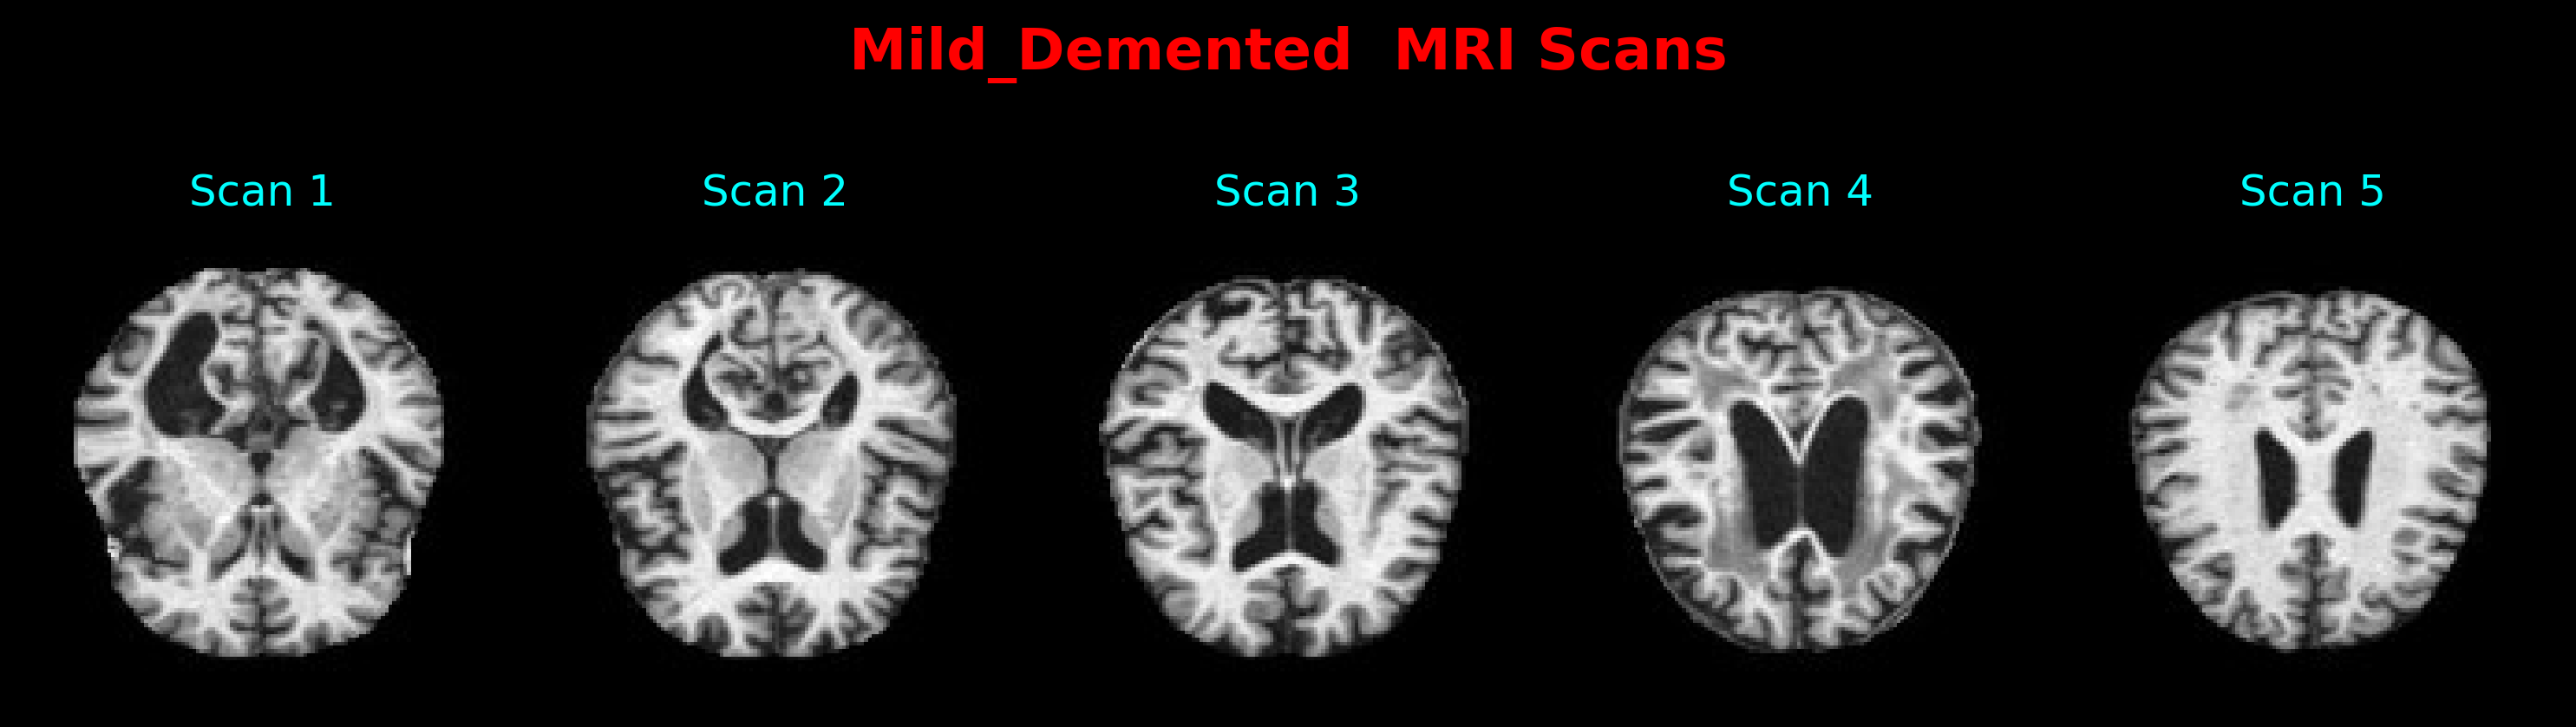

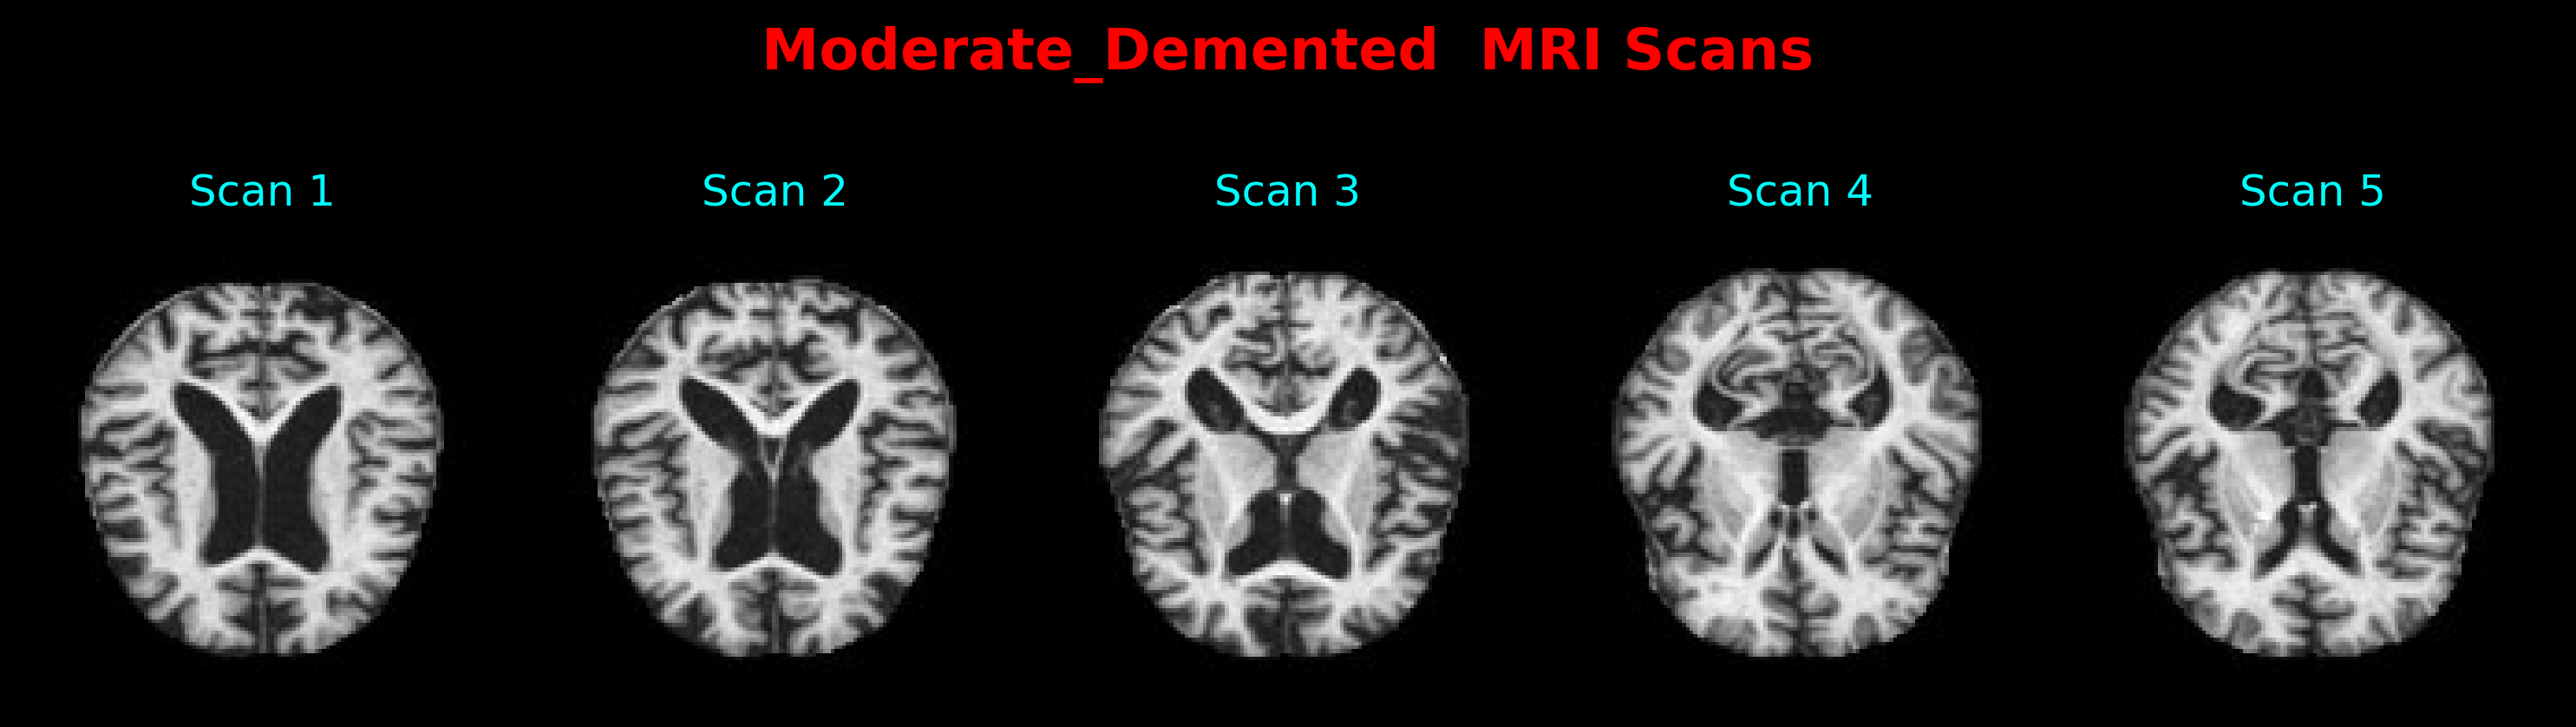

In [6]:
def sample_bringer(path, target, num_samples=5):
    class_path = os.path.join(path, target)
    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="black")
    fig.suptitle(f'{target}  MRI Scans', color="red", fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img, cmap='gray')  # Specify cmap='gray'
        ax[i].axis('off')
        ax[i].set_title(f'Scan {i+1}', color="aqua")

    plt.tight_layout()

# Assuming `class_names` is defined elsewhere in your code
for target in class_names:
    sample_bringer(PATH, target=target)


<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Pixel Normalization</h2>

In [8]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="black")
        fig.suptitle("MRI Scans in a sample batch", color="red",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

In [9]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Dataset Split and Class Weight calculation</h2>

In [10]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.7, val_size=0.2, test_size=0.1)

In [11]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Building Alzh-Net Model</h2>

In [12]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
        
    return model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Define the first model
def conv_block(x, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)
    return x

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
def dense_block(x, units, dropout_rate):
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu')(x)
    return x

IMAGE_SIZE = (176, 176)
input_layer = Input(shape=(*IMAGE_SIZE, 3))

x = Conv2D(16, 3, activation='relu', padding='same')(input_layer)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPool2D()(x)

x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 128)

x = Dropout(0.2)(x)
x = conv_block(x, 256)

x = Dropout(0.2)(x)
x = Flatten()(x)
x = dense_block(x, 512, 0.7)
x = dense_block(x, 128, 0.5)

# Output layer before concatenation
output_layer1 = Dense(4, activation='softmax', name='output_layer1')(x)

# Define the second model
input_layer2 = Input(shape=(176, 176, 3))
x2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(input_layer2)
x2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(x2)
x2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x2)
x2 = tf.keras.layers.MaxPool2D((2, 2), 2, padding='same')(x2)
x2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x2)
x2 = tf.keras.layers.MaxPool2D((2, 2), 2, padding='same')(x2)
x2 = tf.keras.layers.Flatten()(x2)
x2 = tf.keras.layers.Dense(1024, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Output layer before concatenation
output_layer2 = tf.keras.layers.Dense(4, activation='softmax', name='output_layer2')(x2)

# Concatenate the outputs
concatenated_output = Concatenate(name='concatenated_output')([output_layer1, output_layer2])

# Additional dense layer with 4 units
final_output = Dense(4, activation='softmax', name='final_output')(concatenated_output)

model1 = Model(inputs=input_layer, outputs=output_layer1, name="cnn_model")
model2 = Model(inputs=input_layer2, outputs=output_layer2, name="cnn_model_2")

# Merge the two models using Concatenate layer
CALLBACKS = [my_callback]
merged_model = Model(inputs=[input_layer, input_layer2], outputs=final_output, name="merged_model")
merged_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the merged model
merged_model.summary()

# Save the architecture of the merged model to an image file
plot_model(merged_model, show_shapes=True, show_layer_names=True, to_file='Merged_Model.png', rankdir='LR')
model = build_model()

Model: "merged_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 176, 176, 16  2320        ['conv2d[0][0]']                 
                                )                                                      

In [12]:
tf.keras.utils.plot_model(merged_model, to_file='Merged_Model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">CallBacks and HyperParameter setting</h2>

In [13]:
def checkpoint_callback():
    
    checkpoint_filepath = '/tmp/checkpoint'
    
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 50#100
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [14]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks,verbose=0);


Epoch 1: val_accuracy improved from -inf to 0.50859, saving model to /tmp/checkpoint

Epoch 2: val_accuracy did not improve from 0.50859

Epoch 3: val_accuracy did not improve from 0.50859

Epoch 4: val_accuracy improved from 0.50859 to 0.62578, saving model to /tmp/checkpoint

Epoch 5: val_accuracy improved from 0.62578 to 0.76484, saving model to /tmp/checkpoint

Epoch 6: val_accuracy improved from 0.76484 to 0.81641, saving model to /tmp/checkpoint

Epoch 7: val_accuracy improved from 0.81641 to 0.90234, saving model to /tmp/checkpoint

Epoch 8: val_accuracy improved from 0.90234 to 0.94844, saving model to /tmp/checkpoint

Epoch 9: val_accuracy improved from 0.94844 to 0.94922, saving model to /tmp/checkpoint

Epoch 10: val_accuracy did not improve from 0.94922

Epoch 11: val_accuracy improved from 0.94922 to 0.96797, saving model to /tmp/checkpoint

Epoch 12: val_accuracy improved from 0.96797 to 0.97969, saving model to /tmp/checkpoint

Epoch 13: val_accuracy did not improve fro

In [14]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks,verbose=0);


Epoch 1: val_accuracy improved from -inf to 0.51484, saving model to /tmp/checkpoint

Epoch 2: val_accuracy did not improve from 0.51484

Epoch 3: val_accuracy improved from 0.51484 to 0.57344, saving model to /tmp/checkpoint

Epoch 4: val_accuracy improved from 0.57344 to 0.64766, saving model to /tmp/checkpoint

Epoch 5: val_accuracy improved from 0.64766 to 0.83203, saving model to /tmp/checkpoint

Epoch 6: val_accuracy improved from 0.83203 to 0.92188, saving model to /tmp/checkpoint

Epoch 7: val_accuracy improved from 0.92188 to 0.95547, saving model to /tmp/checkpoint

Epoch 8: val_accuracy improved from 0.95547 to 0.96328, saving model to /tmp/checkpoint

Epoch 9: val_accuracy improved from 0.96328 to 0.97812, saving model to /tmp/checkpoint

Epoch 10: val_accuracy improved from 0.97812 to 0.98047, saving model to /tmp/checkpoint

Epoch 11: val_accuracy did not improve from 0.98047

Epoch 12: val_accuracy did not improve from 0.98047

Epoch 13: val_accuracy improved from 0.980

In [15]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/100
139/140 [============================>.] - ETA: 0s - loss: 1.5967 - accuracy: 0.2388
Epoch 1: val_accuracy improved from -inf to 0.50703, saving model to /tmp/checkpoint
140/140 [==============================] - 14s 54ms/step - loss: 1.6056 - accuracy: 0.2400 - val_loss: 1.2127 - val_accuracy: 0.5070
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 1.2381 - accuracy: 0.4685
Epoch 2: val_accuracy did not improve from 0.50703
140/140 [==============================] - 4s 29ms/step - loss: 1.2364 - accuracy: 0.4685 - val_loss: 1.5936 - val_accuracy: 0.3789
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.5162
Epoch 3: val_accuracy improved from 0.50703 to 0.57344, saving model to /tmp/checkpoint
140/140 [==============================] - 5s 38ms/step - loss: 0.9261 - accuracy: 0.5156 - val_loss: 0.9711 - val_accuracy: 0.5734
Epoch 4/100
138/140 [============================>.] - ETA: 0s - loss: 0.7083 - accuracy

<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

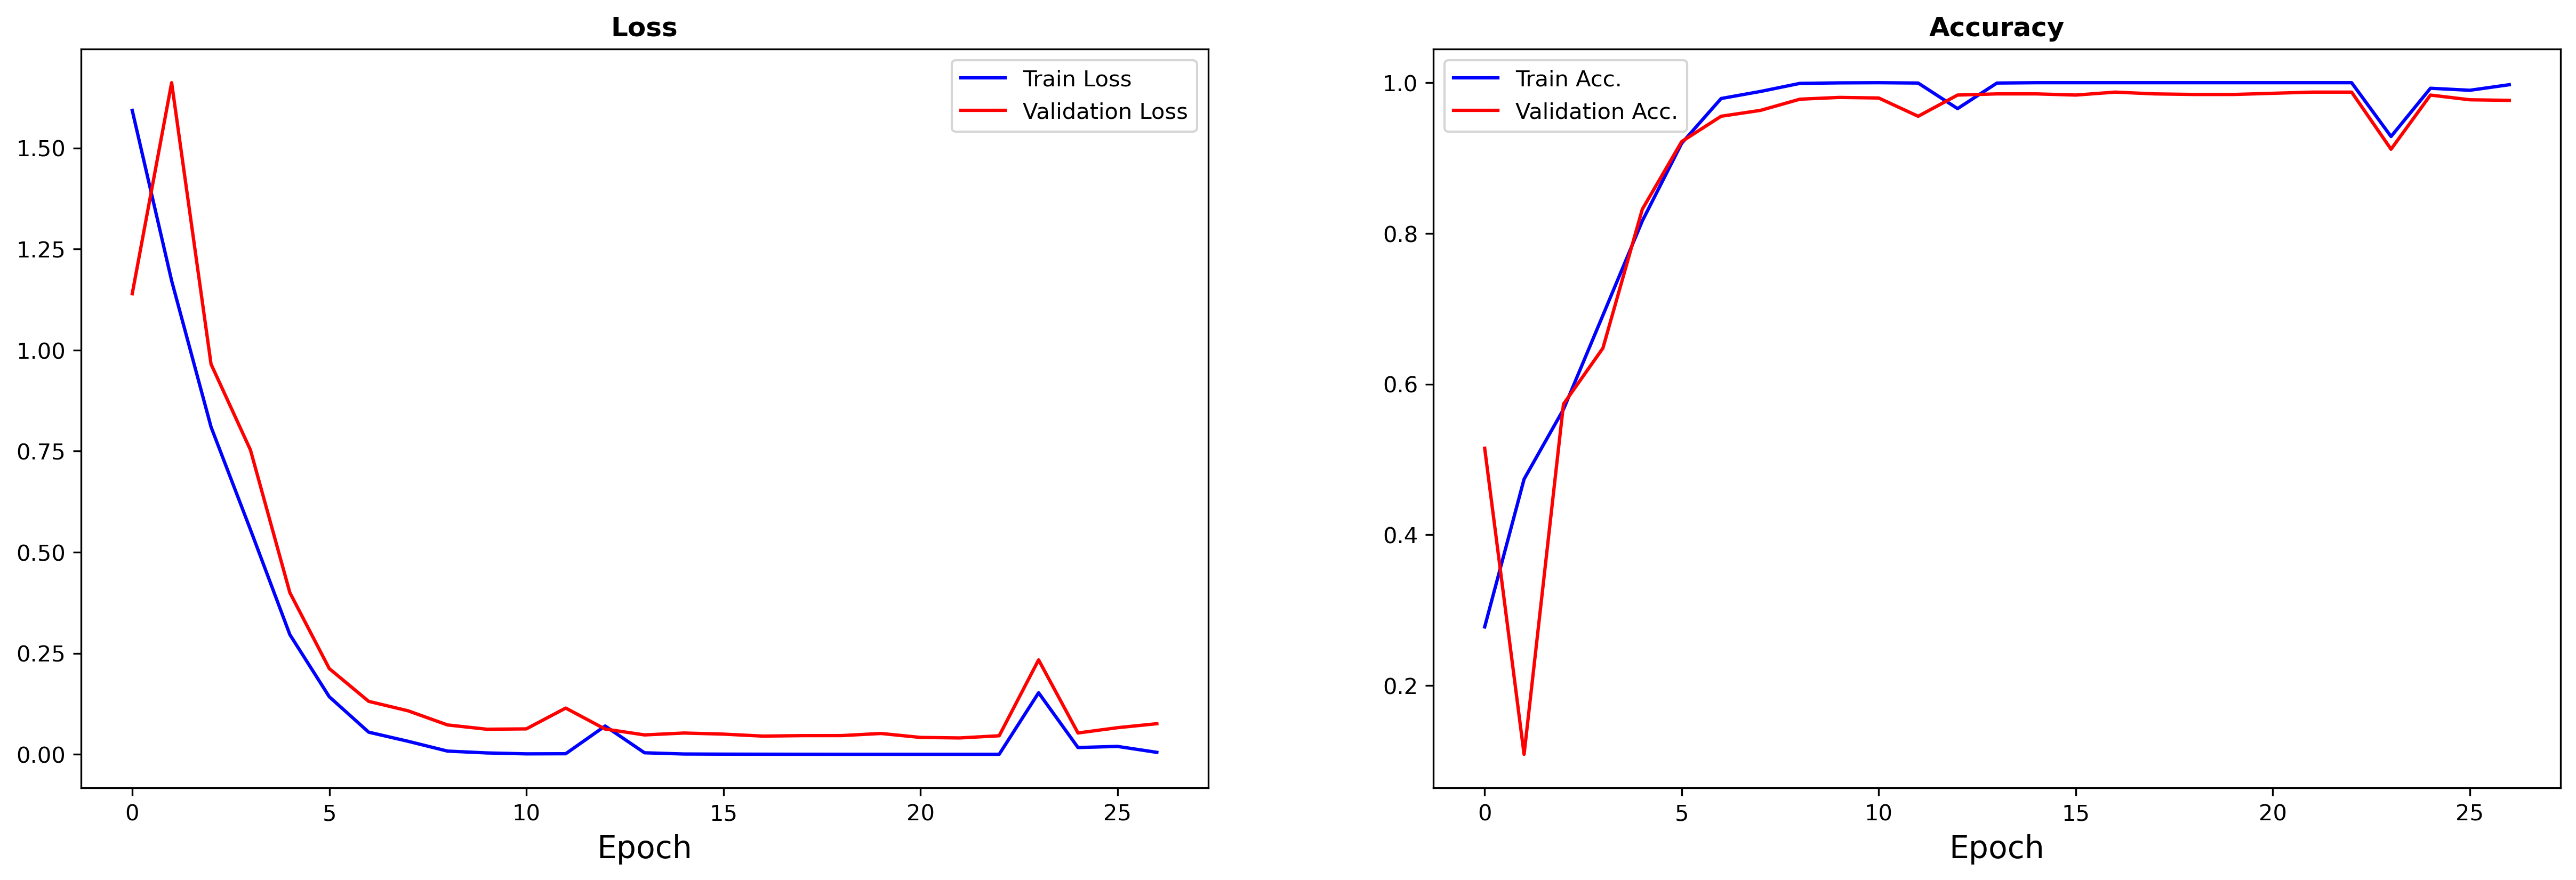

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20,6), facecolor="white")
ax[0].set_facecolor('white')  
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="blue")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="red", )
ax[0].legend()
ax[1].set_facecolor('white')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="blue")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="red")
ax[1].legend()

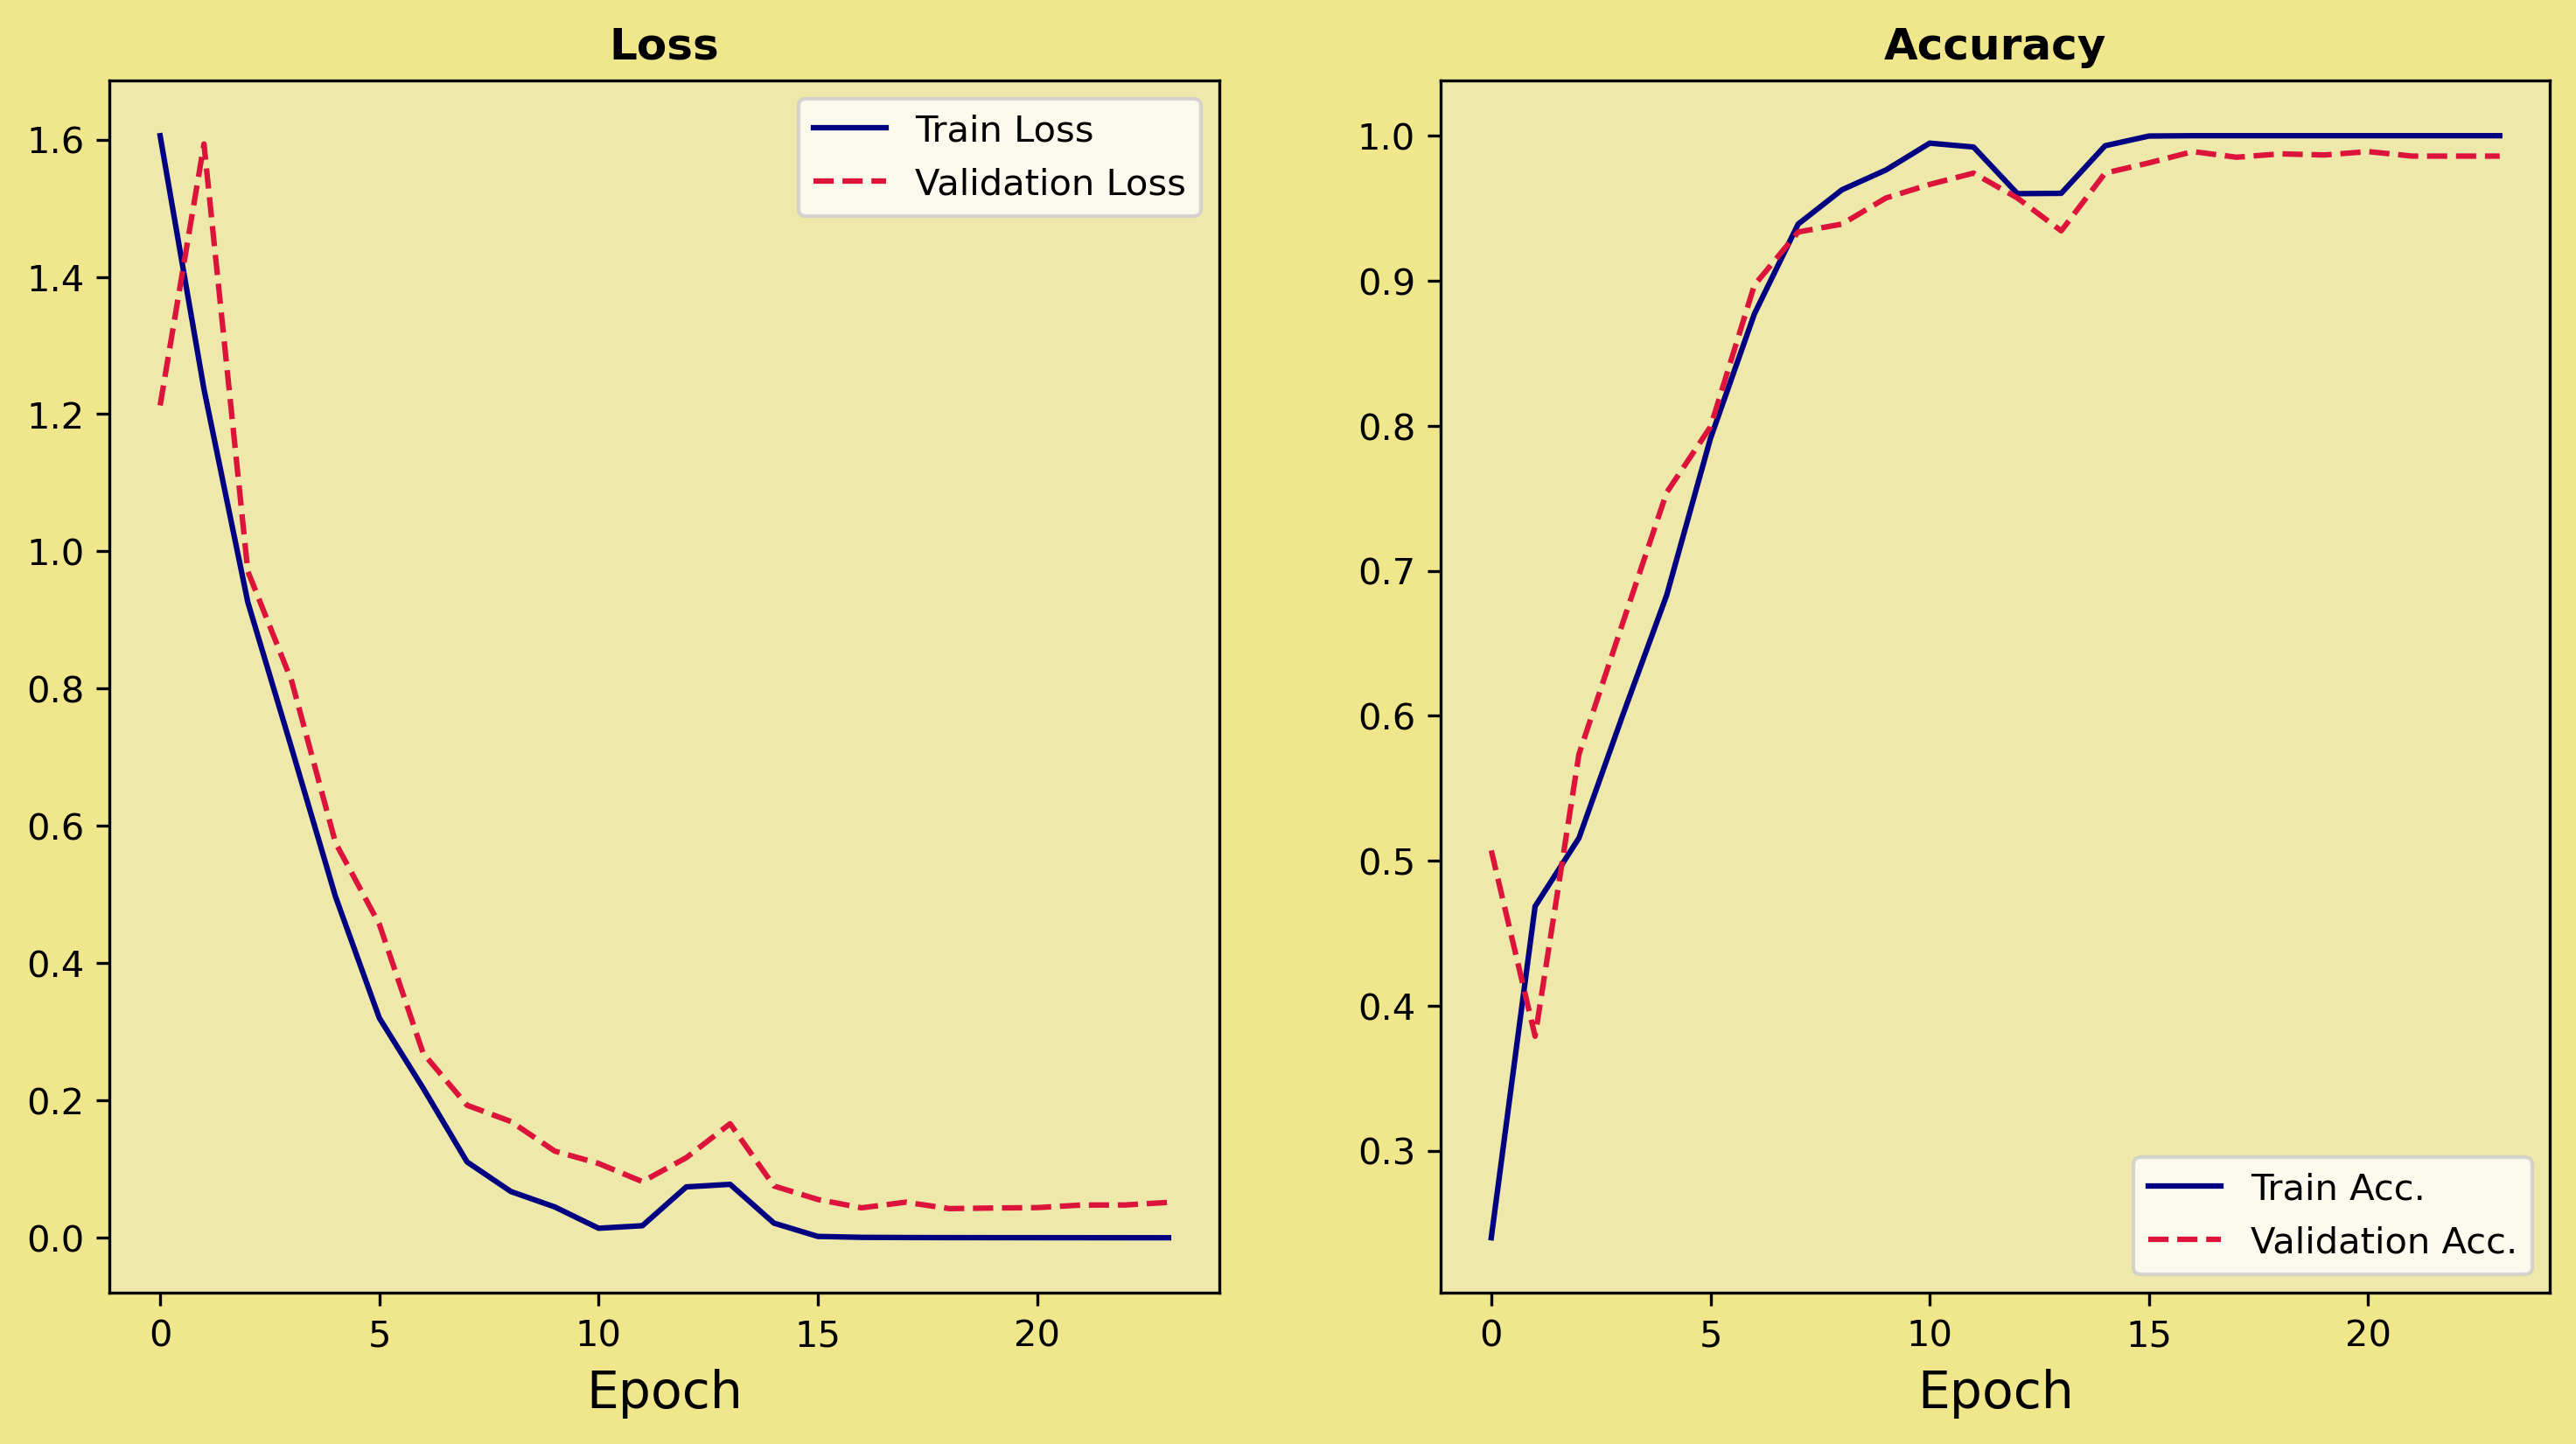

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')  
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Evaluating the model and Classification Report</h2>

In [20]:
model.evaluate(test_data)

20/20 [==============================] - 3s 40ms/step - loss: 0.0861 - accuracy: 0.9781


[0.0861377939581871, 0.9781249761581421]

In [16]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.95      0.98        83
 Moderate_Demented       0.83      1.00      0.91         5
      Non_Demented       0.98      0.99      0.98       320
Very_Mild_Demented       0.98      0.98      0.98       232

          accuracy                           0.98       640
         macro avg       0.95      0.98      0.96       640
      weighted avg       0.98      0.98      0.98       640



In [18]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.96      0.98        85
 Moderate_Demented       0.75      1.00      0.86         3
      Non_Demented       0.98      0.98      0.98       317
Very_Mild_Demented       0.97      0.98      0.98       235

          accuracy                           0.98       640
         macro avg       0.93      0.98      0.95       640
      weighted avg       0.98      0.98      0.98       640



<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Confusion Matrix</h2>

Text(288.1666666666666, 0.5, 'True')

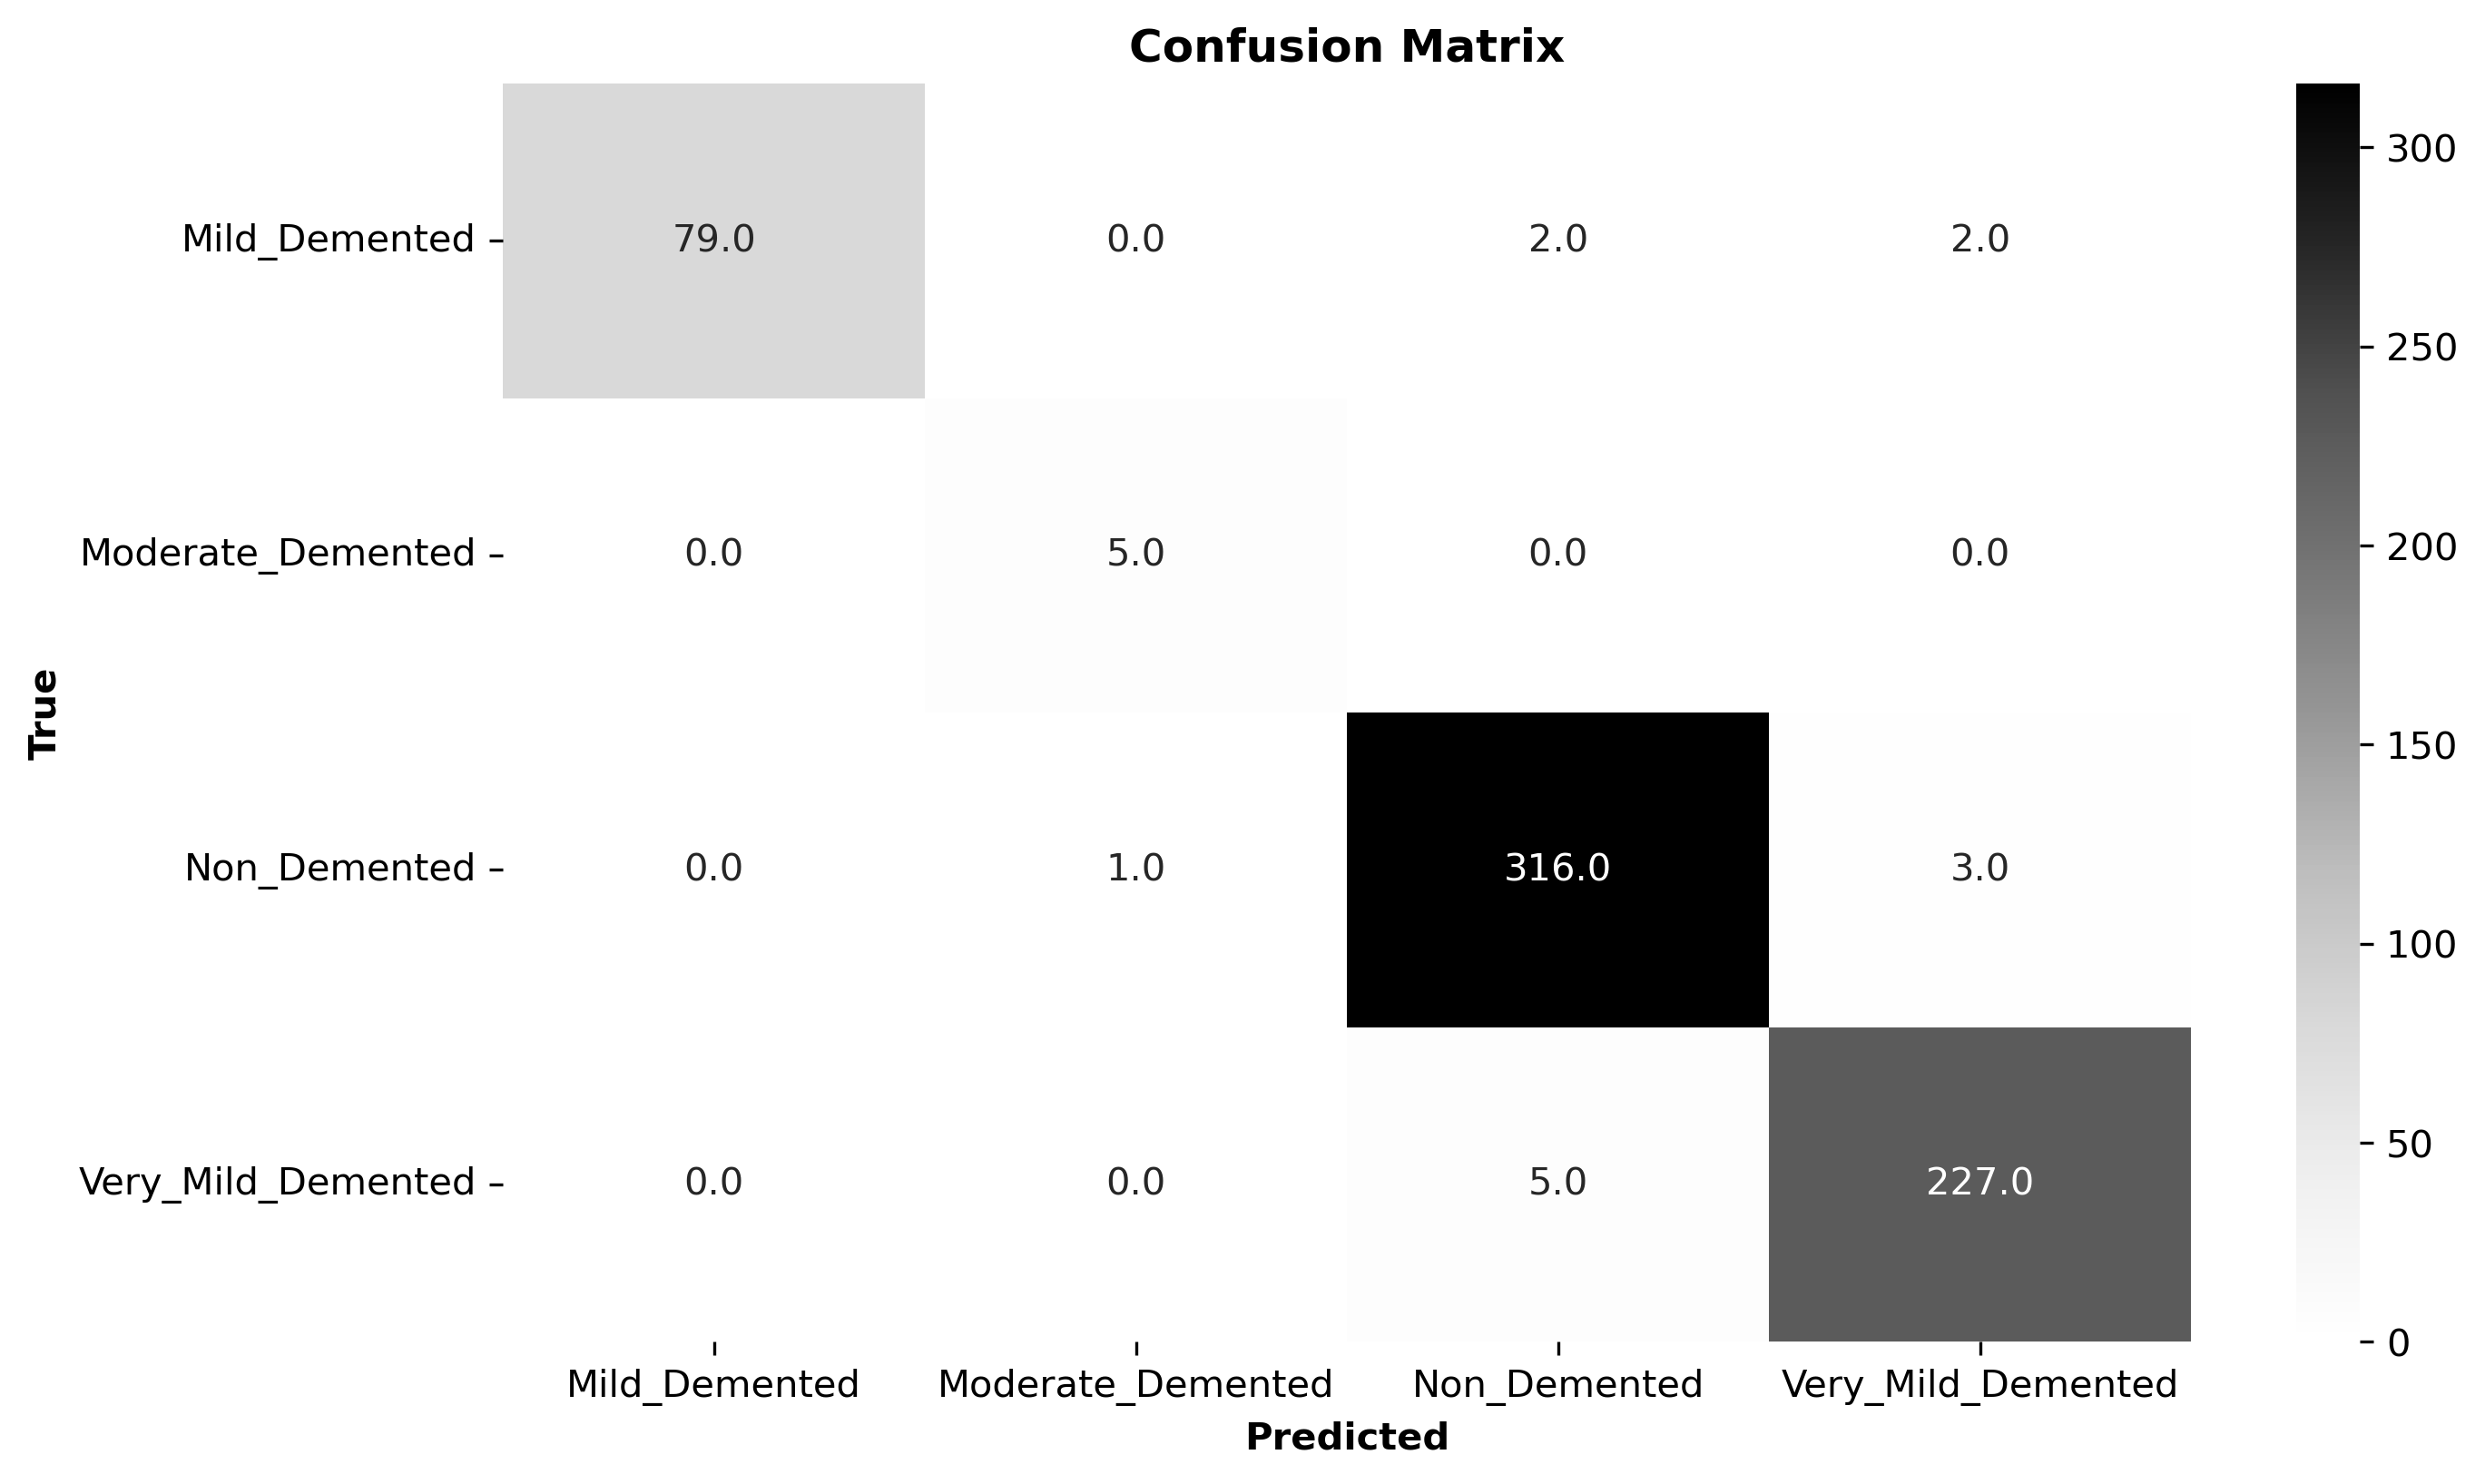

In [17]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

In [18]:
CM = confusion_matrix(labels,predictions)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

array([[ 79,   0,   2,   2],
       [  0,   5,   0,   0],
       [  0,   1, 316,   3],
       [  0,   0,   5, 227]])

<h2 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">Comparing Predicted Classes with the Actual Classes from the Test Data</h2>

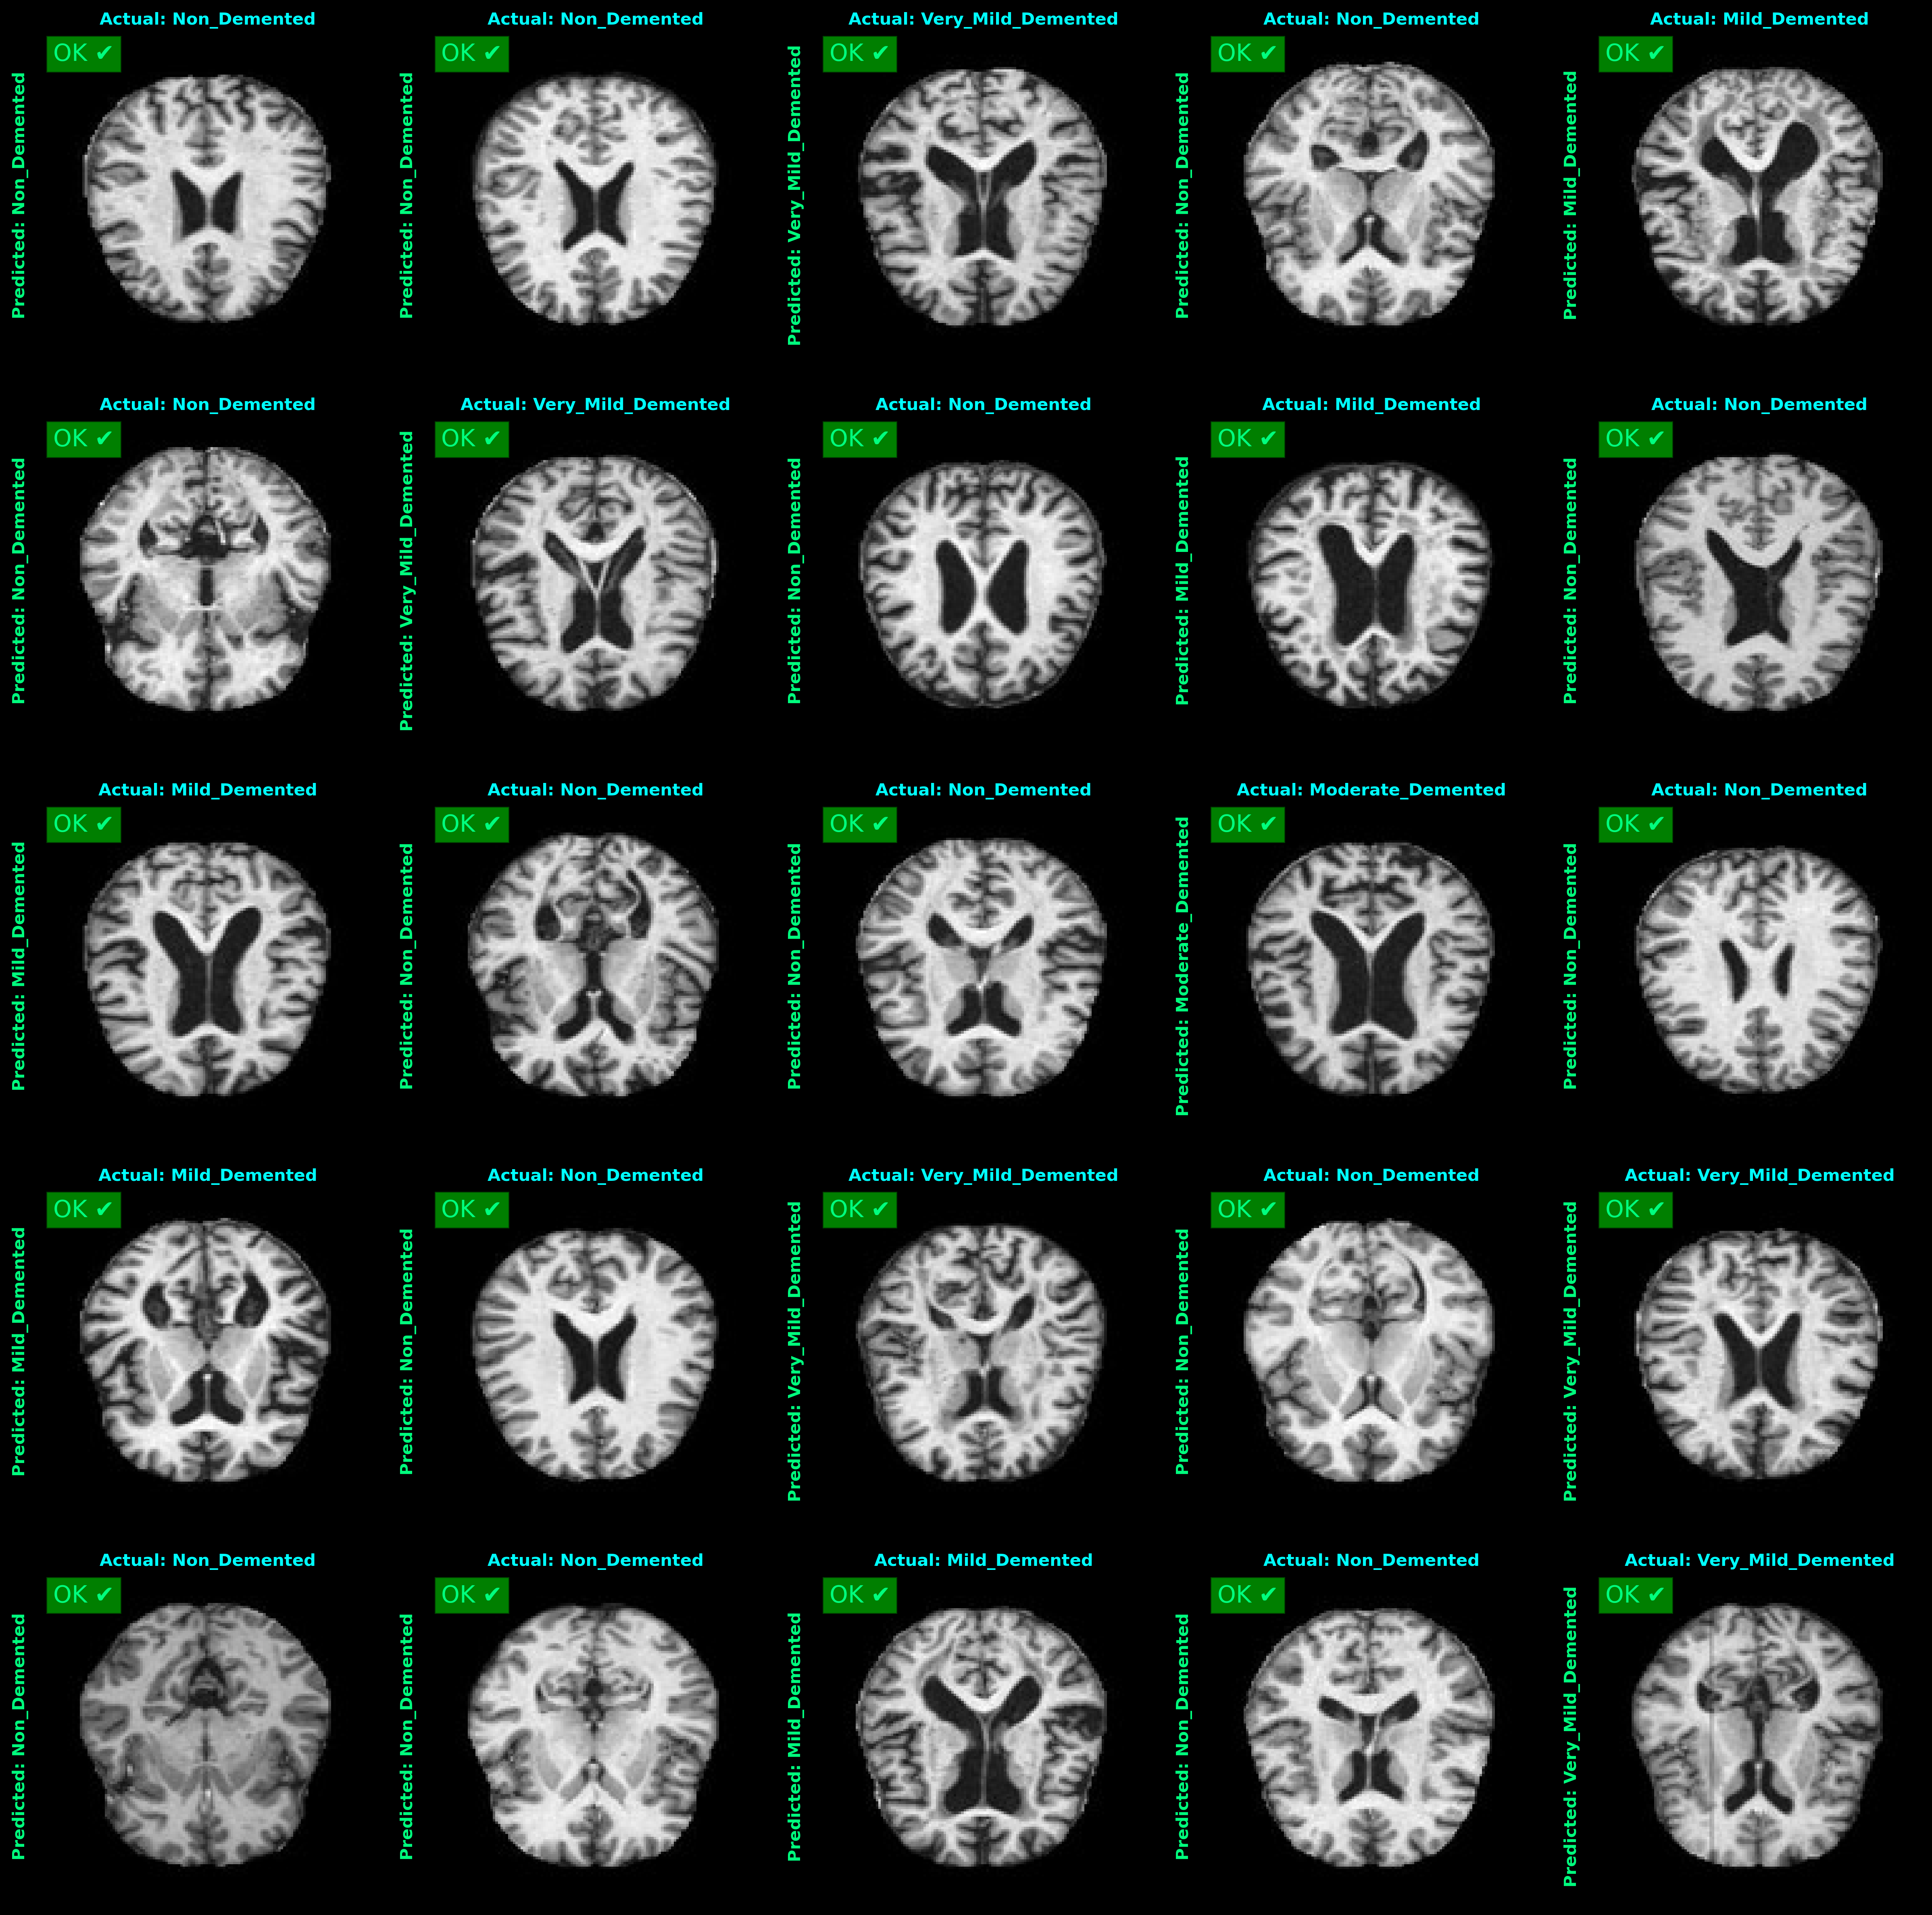

In [28]:
plt.figure(figsize=(20, 20), facecolor="black")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    
        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])